# WNTR Model Development Tutorial

The following tutorial illustrates how to generate water distribution system models from perfect and imperfect geospatial data. The ky4 model is used as the basis of this tutorial, and is used to create the "perfect" geospatial data which accuratly reflects junctions, tanks, reservoirs, pipes, and pumps in the model.  The "imperfect" geospatial data was generated by truncating, skewing, and omitting certain aspects of the perfect datasets. 

Note that additional attributes not contained in geospatial data (i.e., controls, patterns, simulation options) are also added to the model to replicate conditions in ky4.

## Imports
Import WNTR and additional Python packages that are needed for the tutorial
- Geopandas is used to load geospatial data
- Matplotlib is used to create subplots

In [14]:
## Imports
import geopandas as gpd
import matplotlib.pylab as plt
import wntr

crs = "EPSG:3547"  # ft

In [15]:
# TODO, add metadata to hide this cell
wn0 = wntr.network.WaterNetworkModel("../networks/ky4.inp")
wn0.options.time.duration = 24 * 3600
sim = wntr.sim.EpanetSimulator(wn0)
results0 = sim.run_sim()
pressure0 = results0.node["pressure"].loc[24 * 3600, :]
#wntr.graphics.plot_network(wn0, node_attribute=pressure0, node_size=30, title="Pressure")
wntr.network.io.write_geojson(wn0, "../data/ky4", crs=crs)

# junctions should have base demand (see PR)
#aed0 = wntr.metrics.average_expected_demand(wn0)
#print(aed0)
#for name, control in wn0.controls():
#    print(name, control)
#for name, pattern in wn0.patterns():
#    print(name, pattern.multipliers)

# Create a model from perfect geospatial data
The following section creates base `WaterNetworkModel` object from perfect geospatial data.  Information not included in geospatial data (i.e., controls, patterns, initial status, simulation options) are then added to the model.

## Add geospatial data

The GeoJSON files contain complete attributes for junctions, tanks, reservoirs, pipes, and pumps.  

In [16]:
geojson_files = {
    "junctions": "../data/ky4_junctions.geojson",
    "tanks": "../data/ky4_tanks.geojson",
    "reservoirs": "../data/ky4_reservoirs.geojson",
    "pipes": "../data/ky4_pipes.geojson",
    "pumps": "../data/ky4_pumps.geojson",
}

wn = wntr.network.read_geojson(geojson_files)

## Add controls

In [17]:
line = "LINK ~@Pump-1 OPEN IF NODE T-3 BELOW  27.6606"  # 90.75 ft
wn.add_control("Pump1_open", line)

line = "LINK ~@Pump-1 CLOSED IF NODE T-3 ABOVE  32.2326"  # 105.75 ft
wn.add_control("Pump1_closed", line)

## Add a demand pattern

In [18]:
multipliers = [
    0.33, 0.25, 0.209, 0.209, 0.259, 0.36,
    0.529, 0.91, 1.2, 1.299, 1.34, 1.34,
    1.32, 1.269, 1.25, 1.25, 1.279, 1.37,
    1.519, 1.7, 1.75, 1.669, 0.899, 0.479,
]
default_pattern_name = wn.options.hydraulic.pattern
wn.add_pattern(default_pattern_name, multipliers)

## Add pump initial status

In [19]:
pump = wn.get_link("~@Pump-1")
pump.initial_status = "Closed"

## Add simulation options

In [20]:
# TODO, this shoudl be 24, but the simulation doesn't run to completion, due to demands?
wn.options.time.duration = 0  # 24*3600

## Run a hydraulic simulation and plot results

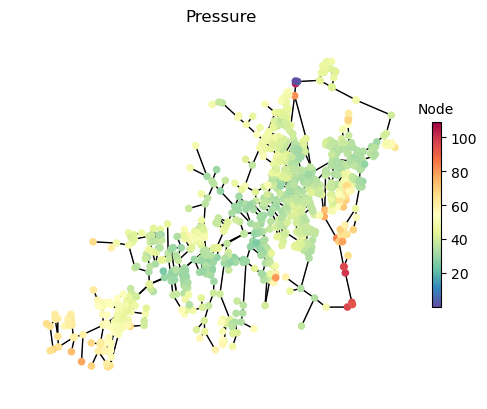

<Axes: title={'center': 'Pressure'}>

In [21]:
#aed = wntr.metrics.average_expected_demand(wn)
#print(aed)
sim = wntr.sim.EpanetSimulator(wn)
results = sim.run_sim()
pressure = results.node["pressure"].loc[0, :]
wntr.graphics.plot_network(wn, node_attribute=pressure, node_size=30, title="Pressure")

In [22]:
wn0.describe()
wn1.describe()
# compare RMSE pressure at a specific time

False

# Create a model from imperfect geospatial data

The following inperfections are included in the following geospatial data
1. Junction data does not exist (no elevation, demand, or coordinates)
2. Pipe data has endpoints that do not align, the pipe data also does not contain start and end node names.

Tank, reservoir, and pump data is complete but needs to be associated with the nearest node

## Refine the geospatial data

### Load data

In [23]:
diconnected_pipes = gpd.read_file("../data/ky4_disconnected_pipes.geojson", crs=crs)
tanks = gpd.read_file("../data/ky4_tanks.geojson", crs=crs)
reservoirs = gpd.read_file("../data/ky4_reservoirs.geojson", crs=crs)
pumps = gpd.read_file("../data/ky4_pumps.geojson", crs=crs)

diconnected_pipes.set_index("index", inplace=True) # This needs to be updated to name
tanks.set_index("name", inplace=True)
reservoirs.set_index("name", inplace=True)
pumps.set_index("name", inplace=True)

# TODO remove start_node_name end_node_name and pumps -- not sure how we add these back in, but I don't think the names should exist here
del pumps['start_node_name']
del pumps['end_node_name']

# Define distance threshold used to refine data
distance_threshold = 100.0

### Connect pipes and define junctions

       CV  diameter status      length  minor_loss  roughness  \
index                                                           
P-1     0    0.1524   Open  536.487929         0.0      150.0   
P-10    0    0.2032   Open   37.839091         0.0      150.0   
P-100   0    0.1524   Open   55.234332         0.0      150.0   
P-1000  0    0.1524   Open  228.380544         0.0      150.0   
P-1001  0    0.1524   Open  144.328591         0.0      150.0   

                                                 geometry start_node_name  \
index                                                                       
P-1     LINESTRING (4971348.280 3905606.319, 4971361.7...               0   
P-10    LINESTRING (4977115.923 3912081.407, 4977018.3...            1618   
P-100   LINESTRING (4951831.196 3894540.658, 4951654.2...               4   
P-1000  LINESTRING (4964997.965 3900078.485, 4965078.2...            2309   
P-1001  LINESTRING (4964667.145 3900419.513, 4964737.3...            2115   

    

<Axes: >

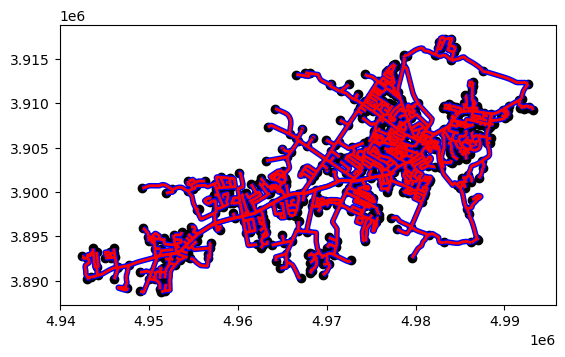

In [24]:
pipes, junctions = wntr.gis.geospatial.connect_lines(diconnected_pipes, distance_threshold)
print(pipes.head())

# TODO, change to plotly or interactive so we can zoom in
fig, ax = plt.subplots()
diconnected_pipes.plot(color="b", linewidth=4, ax=ax)
pipes.plot(color="r", linewidth=2, ax=ax)
junctions.plot(color="k", ax=ax)

### Assign elevation to junctions using a raster

In [25]:
# TODO use sample_raster function
junctions["elevation"] = 100
print(junctions.head())

                             geometry  elevation
0     POINT (4971348.280 3905606.319)        100
1937  POINT (4972891.589 3905044.792)        100
1618  POINT (4977116.192 3912077.244)        100
122   POINT (4977018.019 3912145.762)        100
4     POINT (4951831.196 3894540.658)        100


### Snap reservoirs, tanks, and pumps to the nearest junction

In [26]:
snap_reservoirs = wntr.gis.snap(reservoirs, junctions, distance_threshold)
print(reservoirs.head())
print(snap_reservoirs)

snap_tanks = wntr.gis.snap(tanks, junctions, distance_threshold)
print(tanks.head())
print(snap_tanks)

# TODO, how do we add the pump?  snap to the nearest pipe? why is the pump a point?  does this work with the perfect data above?
snap_pumps = wntr.gis.snap(pumps, junctions, distance_threshold)
print(pumps.head())
print(snap_pumps)

      initial_quality   base_head head_pattern_name  \
name                                                  
R-1               0.0  149.311004              None   

                             geometry  
name                                   
R-1   POINT (4978709.000 3915386.000)  
     node  snap_distance                         geometry
R-1  1284       3.814463  POINT (4978708.437 3915382.227)
       elevation  initial_quality  diameter  init_level  max_level  min_level  \
name                                                                            
T-1   196.940424              0.0   17.6784   25.563576  31.659576  24.039576   
T-2   207.439230              0.0   14.0208   25.732774  31.828770  25.732774   
T-3   217.703095              0.0   13.4112   30.708905  33.756905  27.051299   
T-4   220.580346              0.0   21.3360   29.355660  32.403654  21.735660   

      min_vol overflow vol_curve_name                         geometry  
name                                  

### Connect reservoirs and tanks with a pipe

In [27]:
def add_connector(snap_attribute, pipes):
    for name, row in snap_attribute.iterrows():
        attributes = {'CV': 0, 
                      'diameter': 0.3, 
                      'status': 'Open',
                      'length': 1, 
                      'minor_loss': 0,
                      'roughness': 150,
                      'geometry': row['geometry'],
                      'start_node_name': row['node'],
                      'end_node_name': name}
        pipes.loc[name+'_connector'] = attributes
    return pipes

add_connector(snap_reservoirs, pipes)
add_connector(snap_tanks, pipes)

,CV,diameter,status,length,minor_loss,roughness,geometry,start_node_name,end_node_name
index,,,,,,,,,
P-1,0,0.1524,Open,536.487929,0.0,150.0,"LINESTRING (4971348.280 3905606.319, 4971361.7...",0,1937
P-10,0,0.2032,Open,37.839091,0.0,150.0,"LINESTRING (4977115.923 3912081.407, 4977018.3...",1618,122
P-100,0,0.1524,Open,55.234332,0.0,150.0,"LINESTRING (4951831.196 3894540.658, 4951654.2...",4,1203
P-1000,0,0.1524,Open,228.380544,0.0,150.0,"LINESTRING (4964997.965 3900078.485, 4965078.2...",2309,381
P-1001,0,0.1524,Open,144.328591,0.0,150.0,"LINESTRING (4964667.145 3900419.513, 4964737.3...",2115,2309
...,...,...,...,...,...,...,...,...,...
R-1_connector,0,0.3000,Open,1.000000,0.0,150.0,POINT (4978708.437 3915382.227),1284,R-1
T-1_connector,0,0.3000,Open,1.000000,0.0,150.0,POINT (4959472.582 3897654.880),1291,T-1
T-2_connector,0,0.3000,Open,1.000000,0.0,150.0,POINT (4972994.860 3900302.889),892,T-2


### Connect pumps, oriented based on distance to the reservoir

In [28]:
# TODO
# For each pump
# Determine upstream direction using the graph
# Add upstream junction (junction_upstream)
# Add start_node_name and end_node_name to pump

### Estimate demands from building size

In [29]:
buildings = gpd.read_file("../data/ky4_buildings.geojson", crs=crs)
buildings.to_crs(crs, inplace=True)
buildings["area"] = buildings.area
buildings["base_demand"] = buildings["area"] / 0.00001

buildings.geometry = buildings.geometry.centroid
snap_buildings = wntr.gis.snap(buildings, junctions, distance_threshold)
buildings["junction"] = None
buildings.loc[snap_buildings.index, "junction"] = snap_buildings.loc[:, "node"]

print(buildings.head())

   release   capture_dates_range                         geometry  \
0        2  9/24/2019-10/13/2019  POINT (4992532.866 3912479.401)   
1        2  9/24/2019-10/13/2019  POINT (4989534.777 3908120.496)   
2        2  9/24/2019-10/13/2019  POINT (4989112.060 3908351.808)   
3        2  9/24/2019-10/13/2019  POINT (4988522.750 3906816.347)   
4        2  9/24/2019-10/13/2019  POINT (4989402.147 3908672.352)   

          area   base_demand junction  
0   439.420921  4.394209e+07     None  
1  1852.319947  1.852320e+08     None  
2  1971.192177  1.971192e+08     None  
3  1692.152025  1.692152e+08     None  
4  1514.493614  1.514494e+08     None  


## Build the model

### Add geospatial data

In [30]:
gis_data = wntr.gis.WaterNetworkGIS(
    {
        "junctions": junctions,
        'tanks': tanks,
        'reservoirs': reservoirs,
        "pipes": pipes,
        'pumps': pumps
    }
)
wn = wntr.network.from_gis(gis_data)

AssertionError: 

### Add controls

In [ ]:
line = "LINK ~@Pump-1 OPEN IF NODE T-3 BELOW  27.6606"  # 90.75 ft
wn.add_control("Pump1_open", line)

line = "LINK ~@Pump-1 CLOSED IF NODE T-3 ABOVE  32.2326"  # 105.75 ft
wn.add_control("Pump1_closed", line)

### Add demand pattern and base demand

In [ ]:
multipliers = [
    0.33, 0.25, 0.209, 0.209, 0.259, 0.36,
    0.529, 0.91, 1.2, 1.299, 1.34, 1.34,
    1.32, 1.269, 1.25, 1.25, 1.279, 1.37,
    1.519, 1.7, 1.75, 1.669, 0.899, 0.479,
]
default_pattern_name = wn.options.hydraulic.pattern
wn.add_pattern(default_pattern_name, multipliers)

for i, row in buildings.iterrows():
    junction_name = buildings.loc[i, "junction"]
    if junction_name is None:
        continue
    base_demand = buildings.loc[i, "base_demand"]
    junction = wn.get_node(junction_name)
    junction.demand_timeseries_list.append((base_demand, default_pattern_name, category))

### Add pump initial status

In [ ]:
pump = wn.get_link("~@Pump-1")
pump.initial_status = "Closed"

### Add simulation options

In [ ]:
# TODO, this shoudl be 24, but the simulation doesn't run to completion, due to demands?
wn.options.time.duration = 0  # 24*3600

## Run a hydraulic simulation and plot results

In [ ]:
sim = wntr.sim.EpanetSimulator(wn)
results = sim.run_sim()
pressure = results.node["pressure"].loc[0, :]
wntr.graphics.plot_network(wn, node_attribute=pressure, node_size=30, title="Pressure")

In [ ]:
wn0.describe()
wn2.describe() 
# compare RMSE pressure at a specific time